### Introduction
The objective of this project is to perform an Exploratory Data Analysis (EDA) on Emergency Department (ED) visit stays using the MIMIC-IV (Medical Information Mart for Intensive Care IV) version 2.2 database. This analysis aims to explore the relationship between ED length of stay (LOS) and several demographic and visit-related factors, specifically race, gender, arrival mode, and disposition type.

The MIMIC-IV database is a publicly available dataset that comprises de-identified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center. To ensure patient privacy, identifiable demographic data have been removed, and the original timestamps have been randomly shifted by a consistent amount for each subject, preserving the relative timing of events. This time-shifting allows for accurate calculation of LOS while maintaining patient confidentiality.

Understanding the factors that influence ED LOS is critical for hospital management and patient care optimization. Various factors can impact the duration of an ED stay, but for the purpose of this project, we focus on the following four categories: race, gender, arrival mode, and disposition. Arrival mode and disposition are likely to affect LOS, as they are typically associated with different patient presentations and may require different hospital courses, impacting the overall ED stay. While further investigation is necessary to draw definitive conclusions, this project aims to identify any visual patterns through exploratory visualization.

Additionally, assuming equal treatment across all demographics, we do not expect to see significant differences in LOS across race and gender. However, we acknowledge that many confounding factors may influence these outcomes. This project will primarily utilize Seaborn for data visualization to evaluate these relationships.

### Data Source and Preprocessing
The data for this analysis is sourced from the MIMIC-IV ED version 2.2 dataset. Given the large size of the dataset, we selected a random sub-sample of 1,000 subjects. Each subject may have multiple ED visits recorded over different times, and each encounter is treated as an individual data point. This approach allows us to evaluate longitudinal patterns in future analyses.

To prepare the data for analysis, we performed the following steps:

Data Extraction: Extracted relevant data fields, including demographic information (race, gender), visit details (arrival mode, disposition type), and timestamps.
LOS Calculation: Calculated the ED length of stay for each encounter by utilizing the preserved time deltas, made possible by the consistent time-shifting applied to each subject’s records.
Data Cleaning: Cleaned the data to handle any missing or inconsistent values, ensuring accuracy and reliability in subsequent analyses.
Analysis
The analysis focuses on exploring the relationship between ED LOS and the following factors:

Race: Categories include various racial groups as recorded in the dataset.
Gender: Male and female.
Arrival Mode: Mode of arrival to the ED, such as ambulance, walk-in, etc.
Disposition Type: Outcome of the ED visit, such as admitted to hospital, discharged, etc.
Visualization
Seaborn, a powerful visualization library in Python, is used to create exploratory visualizations. The visualizations include:

Distribution plots to visualize the LOS across different demographic groups.
Box plots and violin plots to compare LOS across different categories of race, gender, arrival mode, and disposition type.
Pair plots to identify potential relationships and interactions between variables.
These visualizations aim to uncover any patterns or disparities in ED LOS based on the specified factors, providing insights for further investigation.

In [1]:
# Setting up environment and importing dependencies
import numpy as np  
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm


These functions are used to clean and process the MIMIC-IV ED dataset. We perform tasks such as loading the data, sampling, remapping race categories, calculating length of stay (LOS), counting visits, and normalizing times. Additionally, we map disposition and arrival categories, and trim the data to remove outliers. This preprocessing ensures that our data is less cluttered and more useful for the subsequent analysis.

In [2]:
def load_data():
    df = pd.read_csv('data/edstays.csv')
    # Convert intime and outtime to datetime, remove hadm_id, and sort by subject_id and intime
    df['intime'] = pd.to_datetime(df['intime'])
    df['outtime'] = pd.to_datetime(df['outtime'])
    df.drop(columns=['hadm_id'], inplace=True)
    df.sort_values(by=['subject_id', 'intime'], inplace=True)
    return df

def sample_data(df):
    # Select a random sample of 10,000 subjects
    sampled_subjects = df['subject_id'].drop_duplicates().sample(10000, random_state=1)
    df = df[df['subject_id'].isin(sampled_subjects)]
    return df

def remap_race(df):
    # Map race categories to simplified groups
    race_map_dict = {
        'WHITE': 'white',
        'ASIAN': 'asian',
        'OTHER': 'other',
        'ASIAN - SOUTH EAST ASIAN': 'asian',
        'UNKNOWN': 'other',
        'BLACK/AFRICAN AMERICAN': 'black',
        'ASIAN - CHINESE': 'asian',
        'WHITE - RUSSIAN': 'white',
        'BLACK/CAPE VERDEAN': 'black',
        'PORTUGUESE': 'white',
        'MULTIPLE RACE/ETHNICITY': 'other',
        'UNABLE TO OBTAIN': 'other',
        'WHITE - OTHER EUROPEAN': 'white',
        'HISPANIC/LATINO - DOMINICAN': 'hispanic',
        'HISPANIC/LATINO - SALVADORAN': 'hispanic',
        'HISPANIC/LATINO - PUERTO RICAN': 'hispanic',
        'WHITE - BRAZILIAN': 'white',
        'HISPANIC/LATINO - GUATEMALAN': 'hispanic',
        'BLACK/CARIBBEAN ISLAND': 'black',
        'HISPANIC OR LATINO': 'hispanic',
        'BLACK/AFRICAN': 'black',
        'AMERICAN INDIAN/ALASKA NATIVE': 'native',
        'ASIAN - KOREAN': 'asian',
        'WHITE - EASTERN EUROPEAN': 'white',
        'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'native',
        'HISPANIC/LATINO - MEXICAN': 'hispanic',
        'PATIENT DECLINED TO ANSWER': 'other',
        'HISPANIC/LATINO - CUBAN': 'hispanic',
        'HISPANIC/LATINO - COLUMBIAN': 'hispanic',
        'ASIAN - ASIAN INDIAN': 'asian',
        'SOUTH AMERICAN': 'hispanic',
        'HISPANIC/LATINO - HONDURAN': 'hispanic',
        'HISPANIC/LATINO - CENTRAL AMERICAN': 'hispanic'
    }
    df['race'] = df['race'].map(race_map_dict)
    df.sort_values(by=['subject_id', 'intime'], inplace=True)
    return df

def get_los(df):
    # Calculate length of stay (LOS) and its logarithm
    df['los'] = (df['outtime'] - df['intime']).dt.total_seconds() // 60
    df['los'] = df['los'].astype(int)
    df['log_los'] = np.log(df['los'] + 1)
    return df

def get_visit_count(df):
    # Count the number of visits per subject
    df = df.sort_values(by=['subject_id', 'intime'])
    df['visit_count'] = df.groupby('subject_id').cumcount() + 1
    df['total_visits'] = df.groupby('subject_id')['visit_count'].transform('count')
    return df

def get_delta_time(df):
    # Calculate time differences between visits
    df['delta_last'] = df.groupby('subject_id')['intime'].diff().dt.days.fillna(0).astype(int)
    df['delta_next'] = (df.groupby('subject_id')['intime'].diff(-1).dt.days.fillna(0).astype(int) * -1) -1
    df['delta_next'] = df['delta_next'].replace(-1, 0)
    df['delta_first'] = (df['intime'] - df.groupby('subject_id')['intime'].transform('min')).dt.days.astype(int)
    return df

def norm_t(df):
    # Normalize intime and outtime relative to the first intime
    df = df.sort_values(by=['subject_id', 'intime'])
    min_intime = df.groupby('subject_id')['intime'].transform('min')
    df['intime'] = (df['intime'] - min_intime).dt.total_seconds().astype(int) // 60
    df['outtime'] = (df['outtime'] - min_intime).dt.total_seconds().astype(int) // 60
    df['los'] = df['outtime'] - df['intime']
    df['log_los'] = np.log(df['los'] + 1)
    return df

def remap_disposition(df):
    # Map and remove certain disposition categories
    df.drop(df[(df['disposition'] == 'OTHER') | (df['disposition'] == 'EXPIRED')].index, inplace=True)
    disposition_mapping = {
        'LEFT WITHOUT BEING SEEN': 'NO_VISIT',
        'LEFT AGAINST MEDICAL ADVICE': 'NO_VISIT',
        'ELOPED': 'NO_VISIT'
    }
    df['disposition'] = df['disposition'].replace(disposition_mapping, regex=True)
    return df

def remap_arrival(df):
    # Remove certain arrival transport categories
    df.drop(df[(df['arrival_transport'] == 'OTHER') | (df['arrival_transport'] == 'UNKNOWN') | (df['arrival_transport'] == 'HELICOPTER')].index, inplace=True)
    return df

def trim_data(df):
    # Compute log_los and remove outliers based on log_los
    df['log_los'] = np.log(df['los'])
    mean_log_los, sd_log_los = norm.fit(df['log_los'])
    range_log_los = (mean_log_los - 4 * sd_log_los, mean_log_los + 4 * sd_log_los)
    print(f"log_los - Mean: {mean_log_los}, SD: {sd_log_los}, Range: {range_log_los}")
    df_trimmed_log_los = df[(df['log_los'] < mean_log_los + 3 * sd_log_los) & (df['log_los'] > mean_log_los - 3 * sd_log_los)]
    print(f"Proportion of data without log_los outliers: {len(df_trimmed_log_los) / len(df):.2%}")
    df.name = "original sample"
    df_trimmed_log_los.name = "samples within x3 SD of log of Length of Stay"
    return df, df_trimmed_log_los


These functions are used for visualizing the relationships and distributions within the dataset:

- viz_pairplot: Creates pair plots to visualize relationships between multiple variables, with different hues representing different categories.
- viz_joingrid: Generates scatter plots to show relationships between two specified variables, with different hues for categorical differentiation.
- viz_density_race_gender_los: Plots Kernel Density Estimations (KDEs) to visualize the distribution of the logarithm of length of stay (log(LOS)) by gender and race, including the normal distribution for comparison.
- viz_density_dispo_los: Similar to the previous function, but visualizes the distribution of log(LOS) by arrival transport and disposition.

In [3]:
def viz_pairplot(df, cols, hue):
    # Create pair plots to visualize relationships between variables
    title = f'{df.name} encoded by {hue}'
    sns.pairplot(data=df, vars=cols, hue=hue)
    plt.suptitle(title, y=1.02)
    plt.show()

def viz_joingrid(df, col, hue):
    # Create scatter plots to visualize relationships between two variables
    plot = sns.scatterplot(data=df, x=col[0], y=col[1], hue=hue)
    plot.legend(loc='upper left', fontsize=8)
    return plot

def viz_density_race_gender_los(df):
    # Visualize the distribution of length of stay (LOS) by gender and race
    df['log_los'] = np.log(df['los'])

    # KDE plot for gender vs log(LOS)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=df, x='log_los', hue='gender', multiple='fill', clip=(0, None), ax=ax1)
    ax1.set_title(f'Distribution of Gender vs Log LOS in {df.name}')
    ax1.set_xlabel('Log LOS')
    ax1.set_ylabel('Density')
    
    mean_log_los = df['log_los'].mean()
    std_log_los = df['log_los'].std()
    x = np.linspace(df['log_los'].min(), df['log_los'].max(), 100)
    y = norm.pdf(x, mean_log_los, std_log_los)
    ax2 = ax1.twinx()
    ax2.plot(x, y, 'k--', label='Normal Distribution')
    ax2.set_ylabel('Normal Distribution Density')
    ax2.legend(loc='upper right')
    plt.show()
    
    # KDE plot for race vs log(LOS)
    fig2, ax1 = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=df, x='log_los', hue='race', multiple='fill', clip=(0, None), ax=ax1)
    ax1.set_title(f'Density of Race vs Log LOS in {df.name}')
    ax1.set_xlabel('Log LOS')
    ax1.set_ylabel('Density')
    
    ax2 = ax1.twinx()
    ax2.plot(x, y, 'k--', label='Normal Distribution')
    ax2.set_ylabel('Normal Distribution Density')
    ax2.legend(loc='upper right')
    plt.show()
    
    return fig1, fig2

def viz_density_dispo_los(df):
    # Visualize the distribution of LOS by arrival transport and disposition
    df['log_los'] = np.log(df['los'])

    # KDE plot for arrival transport vs log(LOS)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=df, x='log_los', hue='arrival_transport', multiple='fill', clip=(0, None), ax=ax1)
    ax1.set_title(f'Density of Arrival Transport vs Log LOS in {df.name}')
    ax1.set_xlabel('Log LOS')
    ax1.set_ylabel('Density')
    
    mean_log_los = df['log_los'].mean()
    std_log_los = df['log_los'].std()
    x = np.linspace(df['log_los'].min(), df['log_los'].max(), 100)
    y = norm.pdf(x, mean_log_los, std_log_los)
    ax2 = ax1.twinx()
    ax2.plot(x, y, 'k--', label='Normal Distribution')
    ax2.set_ylabel('Normal Distribution Density')
    ax2.legend(loc='upper right')
    plt.show()
    
    # KDE plot for disposition vs log(LOS)
    fig2, ax1 = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=df, x='log_los', hue='disposition', multiple='fill', clip=(0, None), ax=ax1)
    ax1.set_title(f'Density of Disposition vs Log LOS in {df.name}')
    ax1.set_xlabel('Log LOS')
    ax1.set_ylabel('Density')
    
    ax2 = ax1.twinx()
    ax2.plot(x, y, 'k--', label='Normal Distribution')
    ax2.set_ylabel('Normal Distribution Density')
    ax2.legend(loc='upper right')
    plt.show()
    
    return fig1, fig2


In this section, we load and prepare the data for analysis. The steps include:

- Loading the Data: We load the raw data from the MIMIC-IV ED dataset and create a copy for processing.
- Sampling: We select a random sample of 10,000 subjects to make the data more manageable.
- Remapping Race: We simplify race categories for better analysis.
- Visit Counts: We calculate the number of visits for each subject.
- Time Differences: We compute the time differences between visits.
- Normalization: We normalize the intime and outtime relative to the first visit's intime.
- Remapping Disposition: We map and remove certain disposition categories.
- Filtering Arrival Transport: We remove certain arrival transport categories to focus on relevant data.
- Resetting Index: We reset the index for the cleaned DataFrame.
- Finally, we print the columns and display the first 10 rows of the DataFrame to verify the preprocessing steps.

In [4]:
df_raw = load_data()
df = df_raw.copy() # Load the raw data and create a copy for processing
df = sample_data(df) # Sample the data to get a subset of 10,000 subjects
df = remap_race(df) # Remap race categories to simplified groups
df = get_visit_count(df) # Get visit counts for each subject
df = get_delta_time(df) # Calculate time differences between visits
df = norm_t(df) # Normalize intime and outtime relative to the first intime
df = remap_disposition(df) # Remap and remove certain disposition categories
df = remap_arrival(df) # Remove certain arrival transport categories
df.reset_index(drop=True, inplace=True) # Reset the index
print(df.columns) # Print the columns of the DataFrame
df.head(10) # Display the first 10 rows of the DataFrame


Index(['subject_id', 'stay_id', 'intime', 'outtime', 'gender', 'race',
       'arrival_transport', 'disposition', 'visit_count', 'total_visits',
       'delta_last', 'delta_next', 'delta_first', 'los', 'log_los'],
      dtype='object')


subject_id   stay_id   intime  outtime gender   race arrival_transport  \
0    10002852  39437048        0      309      F  white           WALK IN   
1    10003137  31949628        0      110      F  other           WALK IN   
2    10003137  37049557    47413    47705      F  other           WALK IN   
3    10003137  39628693   327045   327197      F  other           WALK IN   
4    10003137  39960176   623829   624034      F  other           WALK IN   
5    10004439  34840402        0      127      M  other         AMBULANCE   
6    10005464  33455046        0      434      M  white         AMBULANCE   
7    10006457  32296708        0      351      F  other           WALK IN   
8    10006457  39217179   382649   382915      F  black           WALK IN   
9    10006457  30156474  1061098  1061413      F  black           WALK IN   

  disposition  visit_count  total_visits  delta_last  delta_next  delta_first  \
0        HOME            1             1           0           0            0   
1        HOME            1             4           0          32            0   
2        HOME            2             4          32         194           32   
3        HOME            3             4         194         206          227   
4        HOME            4             4         206           0          433   
5        HOME            1             1           0           0            0   
6        HOME            1             1           0           0            0   
7    ADMITTED            1             8           0         265            0   
8        HOME            2             8         265         471          265   
9        HOME            3             8         471         602          736   

   los   log_los  
0  309  5.736572  
1  110  4.709530  
2  292  5.680173  
3  152  5.030438  
4  205  5.327876  
5  127  4.852030  
6  434  6.075346  
7  351  5.863631  
8  266  5.587249  
9  315  5.755742

In this section, we visualize the relationships between various variables in our sampled data. We focus on the following columns:

- log_los: Logarithm of length of stay
- visit_count: Number of visits per subject
- total_visits: Total visits per subject
- delta_last: Time since the last visit
- delta_next: Time until the next visit
- delta_first: Time since the first visit

We use the viz_pairplot function to create pair plots, which help in understanding the pairwise relationships between these variables. The visualizations are color-coded by two categorical variables: race and disposition. This allows us to explore how these categories might influence or correlate with the variables of interest.

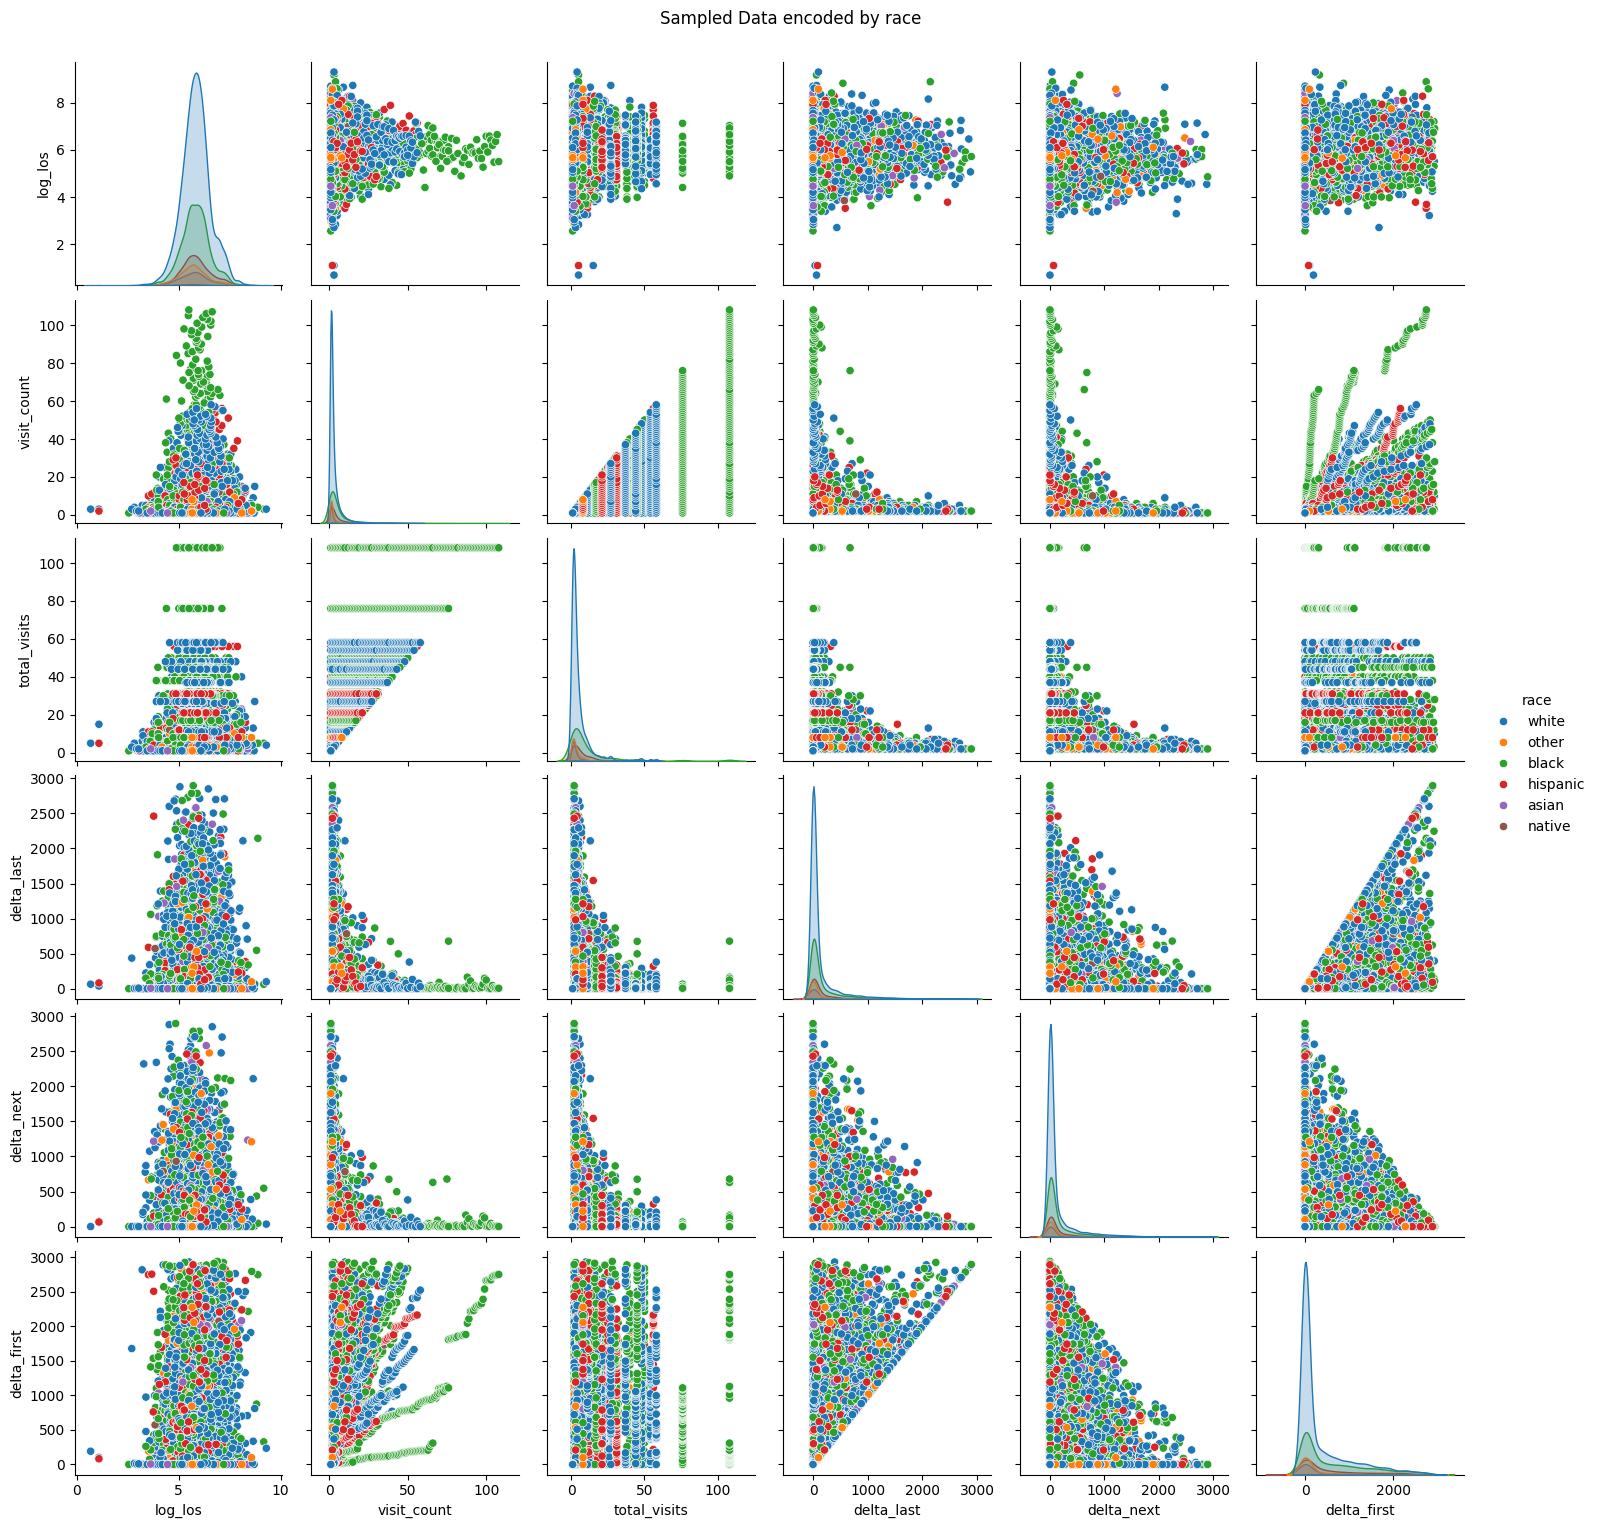

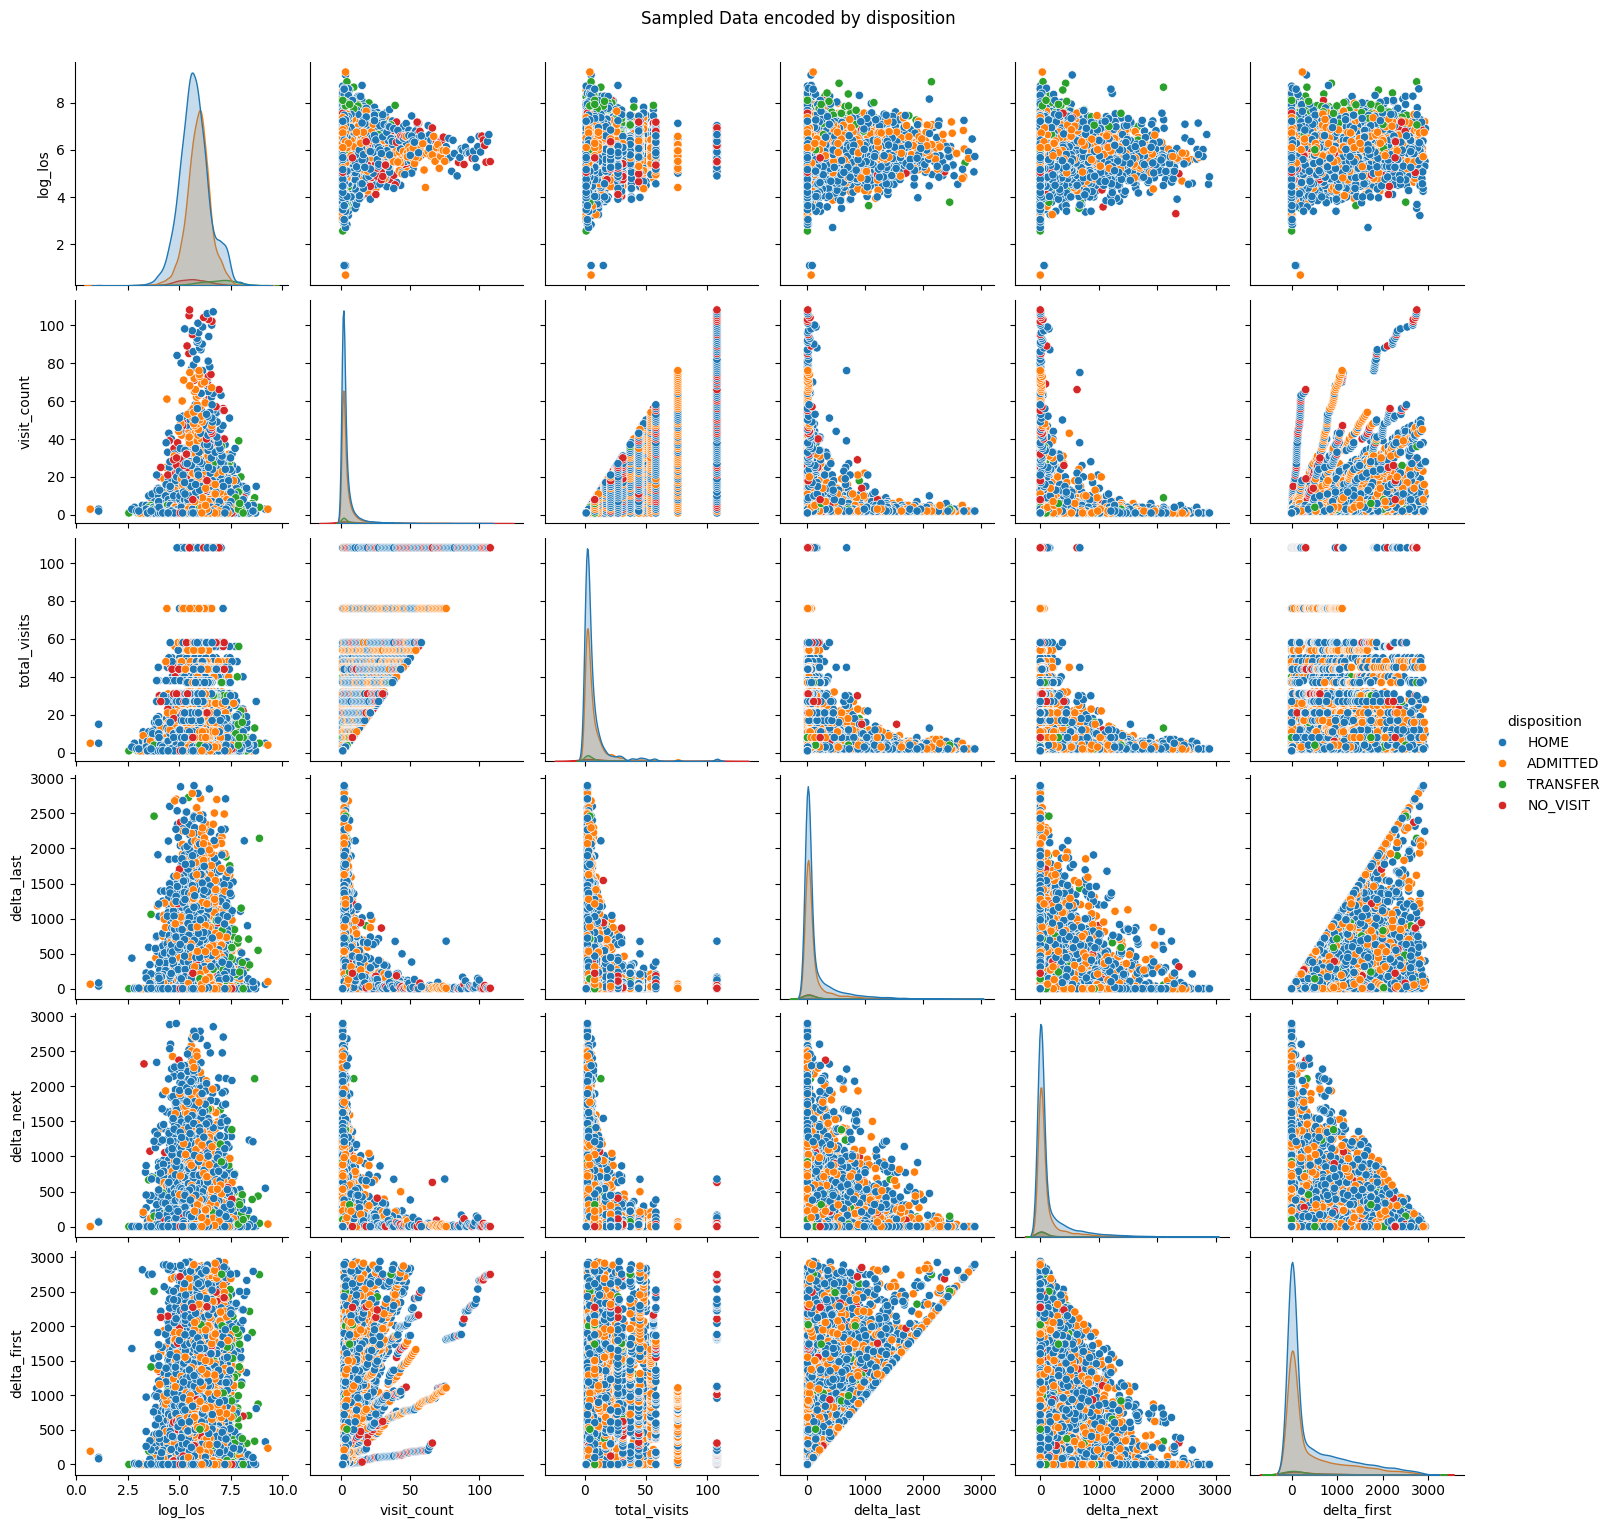

In [5]:
cols = ['log_los', 'visit_count', 'total_visits', 'delta_last', 'delta_next', 'delta_first']
sampled_df = df.copy() # Create a copy of the DataFrame for visualization
sampled_df.name = "Sampled Data" # Name the DataFrame for use in titles

# Visualize relationships between variables, colored by race
viz_pairplot(sampled_df, cols, 'race')

# Visualize relationships between variables, colored by disposition
viz_pairplot(sampled_df, cols, 'disposition')


The pair plot visualizes relationships between key variables in the dataset, color-coded by race and dispotion. Main findings include:

- log_los vs. visit_count and total_visits: There is a noticeable spread, with higher visit counts and total visits showing a wider range of log_los.
- The distribution of data points across different races and dispositions appears relatively uniform. There are no strong race-based differences in the relationships between the numerical variables. However, there appear to be some outliers.

To better visualize and analyze the data, we will trim the data to include only those data points that fall within 3 standard deviations (SD) of the mean of log_los. This will help reduce the impact of outliers and provide a clearer understanding of the underlying patterns in the data.

Trimming Statistics:
- Mean of log_los: 5.8238
- Standard Deviation (SD) of log_los: 0.7103
- Range for trimming: (2.9826, 8.6649)
- Proportion of data without log_los outliers: 99.31%


In [7]:
dfs = trim_data(df) # Trim the data to include only those points within 3 SD of the mean of log_los, the function returns the original and trimmed dataframes

log_los - Mean: 5.823752584900967, SD: 0.7102764356701695, Range: (2.9826468422202885, 8.664858327581644)
Proportion of data without log_los outliers: 99.31%


In this section, we visualize the relationships in the trimmed data across various categories. We use scatter plots to analyze how log_los and visit_count relate to different hues: race, gender, disposition, and arrival transport.

The scatter plots of the trimmed data show that the relationships between log_los and visit_count are relatively uniform across different categories (race, gender, disposition, and arrival transport). The main findings include:

- No strong race-based differences in the relationship between log_los and visit_count.
- Gender distribution is consistent across both original and trimmed samples.
- Disposition categories do not show significant differences in the relationships.
- Arrival transport modes appears to be uniformly distributed across the variables.

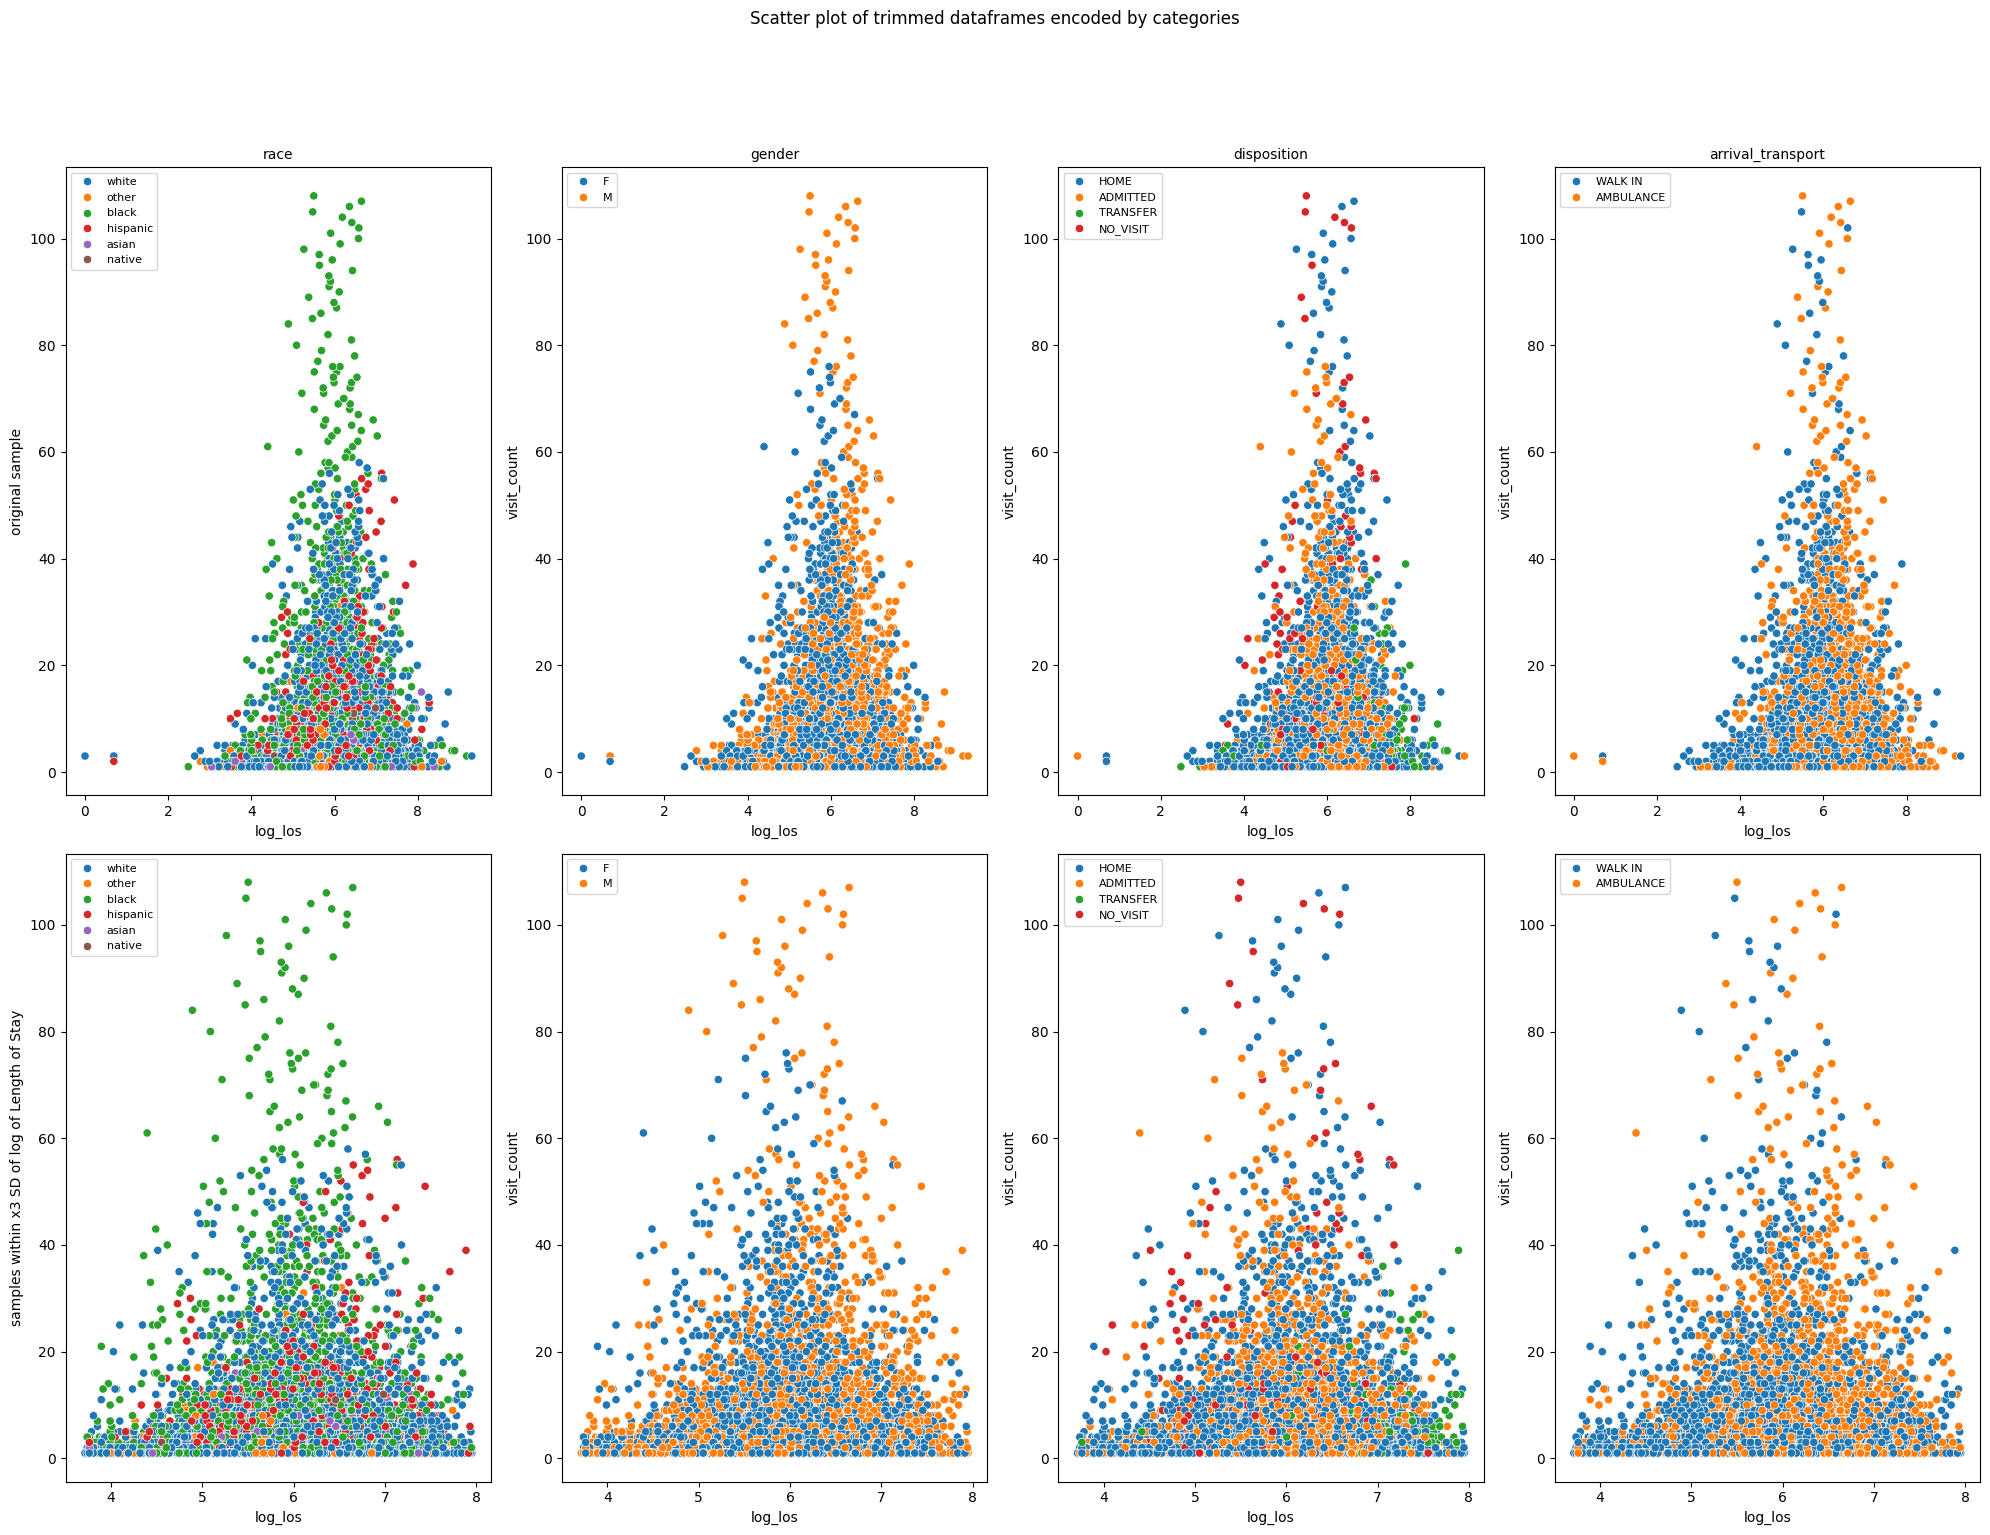

In [8]:
# Define columns and hues
col_grid = ['log_los', 'visit_count']
hues = ['race', 'gender', 'disposition', 'arrival_transport']

# Create a figure with subplots (4 columns x 2 rows)
fig, axes = plt.subplots(2, 4, figsize=(20, 15))

for i, df in enumerate(dfs):
    for j, hue in enumerate(hues):
        ax = axes[i, j]
        plt.sca(ax)  # Set the current axes
        viz_joingrid(df, col_grid, hue)
        if j == 0:
            ax.set_ylabel(df.name, fontsize=10)  # Set y-axis label for the first column
        if i == 0:
            ax.set_title(hue, fontsize=10)  # Set title for the first row

# Add a title for the entire figure
fig.suptitle('Scatter plot of trimmed dataframes encoded by categories', fontsize=12, y=1.02)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



These density plots visualize the distribution of log_los (logarithm of length of stay) against various categories: arrival transport and disposition. The plots are separated into two sets: the original sample and the trimmed sample within 3 standard deviations of the mean log_los.

Points to Consider:
### Density Plot and KDE Line:
    - The density plot can amplify proportions, particularly when the number of data points is smaller as we move away from the mean. To better understand this effect, a KDE line representing a normal distribution with the same mean and standard deviation is added to the plot.

### Increased Density Around the Mean:
    - The trimming process enhances the visualization by reducing the impact of outliers and providing a more accurate representation of the data distributions.

### Real-World Implications:
    - Ambulance Arrivals: The density of patients brought in by ambulance increases around the mean log_los. This can be explained by the fact that patients arriving by ambulance typically require more thorough workups, leading to longer stays.
    - Hospital Admissions: Similarly, the density of patients admitted to the hospital increases with longer lengths of stay. These patients often require extensive evaluations and treatments, contributing to longer ED stays.
    - Transfers: The higher density of transfers at the extremities can be attributed to real-world scenarios where patients require transfer to different facilities or need to stay in the ED until arrangements are made.


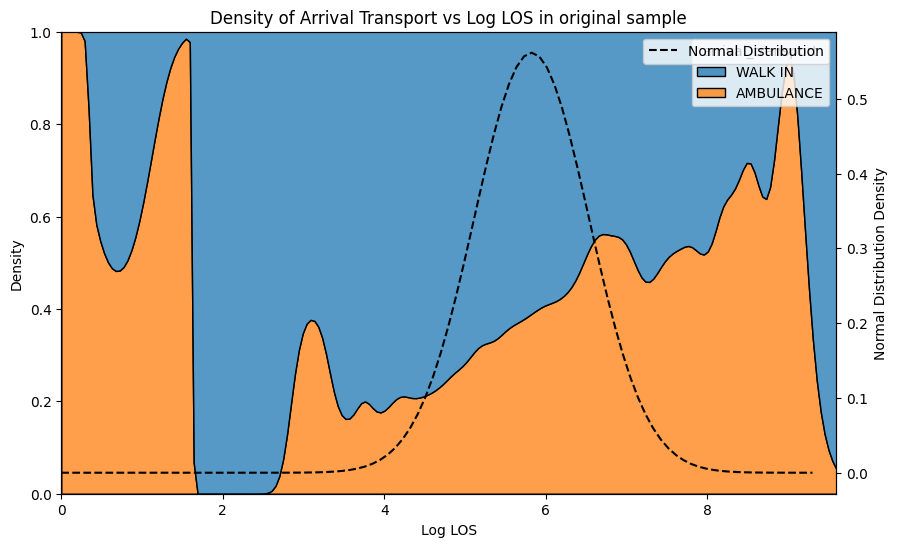

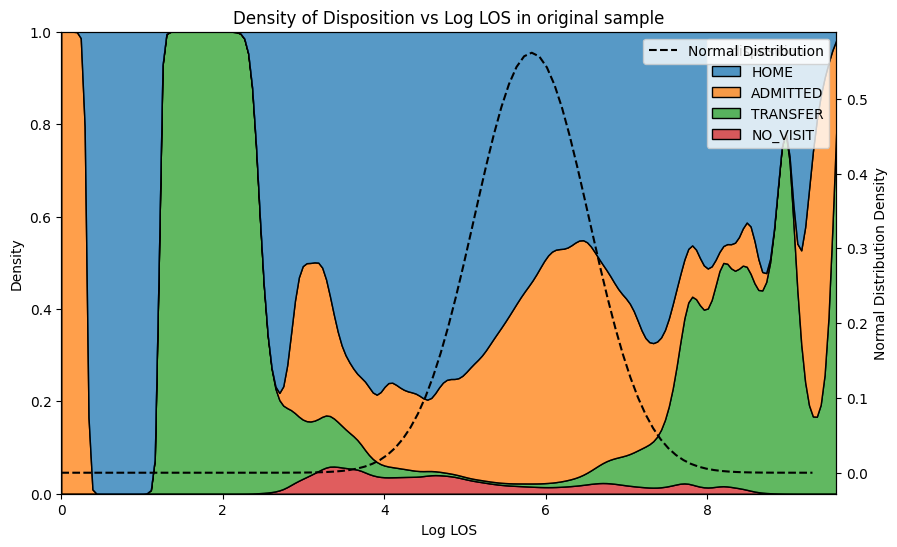

/var/folders/nf/90z5s79x3vd9_8s47vmw3dpw0000gn/T/ipykernel_56519/684740955.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_los'] = np.log(df['los'])


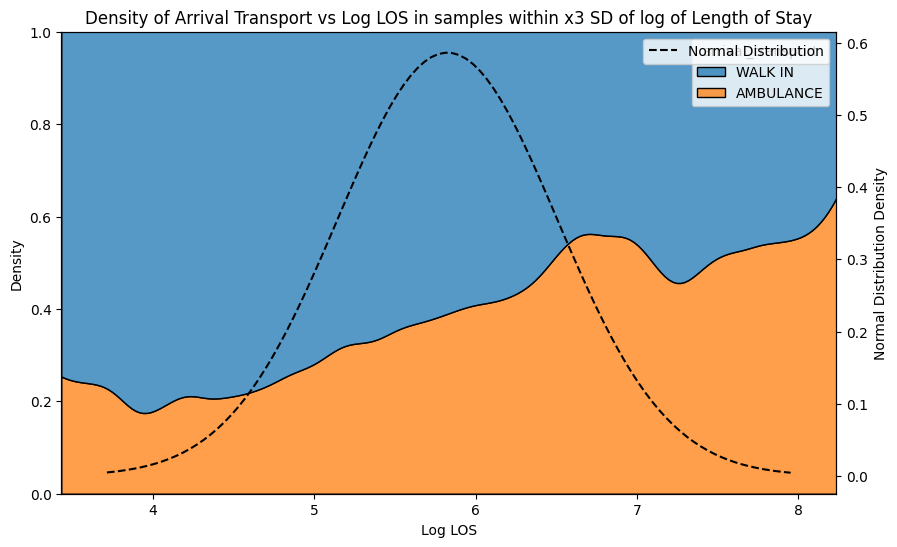

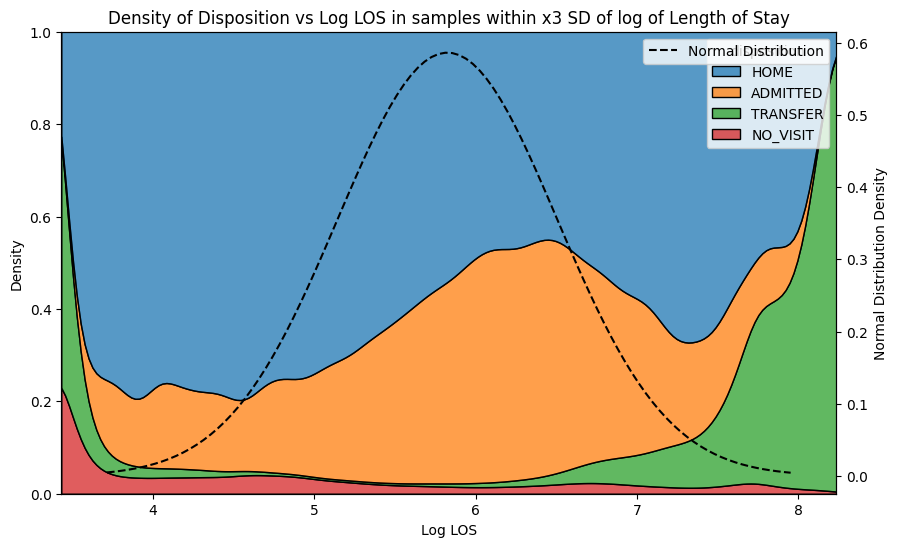

In [46]:

for df in dfs:
    viz_density_dispo_los(df)


These density plots visualize the distribution of log_los (logarithm of length of stay) against race and gender for both the original sample and the trimmed sample within 3 standard deviations of the mean log_los.

### Key Points:
 - KDE Line: A KDE line representing a normal distribution is added to the plots. This line helps to show the distribution, especially since data points at the extremities can amplify density differences. This effect is reduced in the trimmed data.

### Density of Race vs. Log LOS (Original and Trimmed Samples)
 - Insights: There is no significant correlation between LOS and density of various races. However, minorities tend to have higher densities at the extremes.

### Density of Gender vs. Log LOS (Original and Trimmed Samples)
 - No significant correlation between LOS and gender density. Both males and females show similar density patterns. However, males tend to have higher densities at the extremes.

### Conclusion
 - Further statistical analysis is warranted to determine if the differences in densities, particularly for minorities at the extremes, are statistically significant.

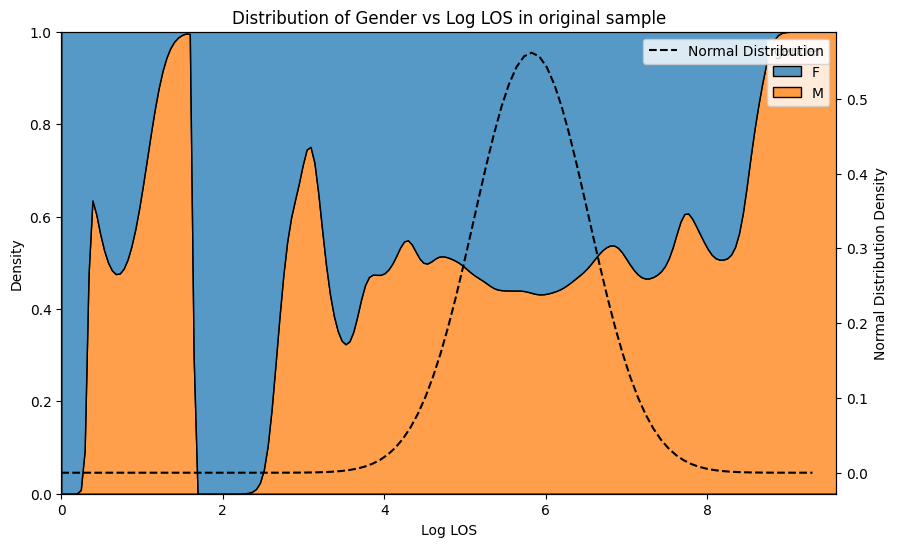

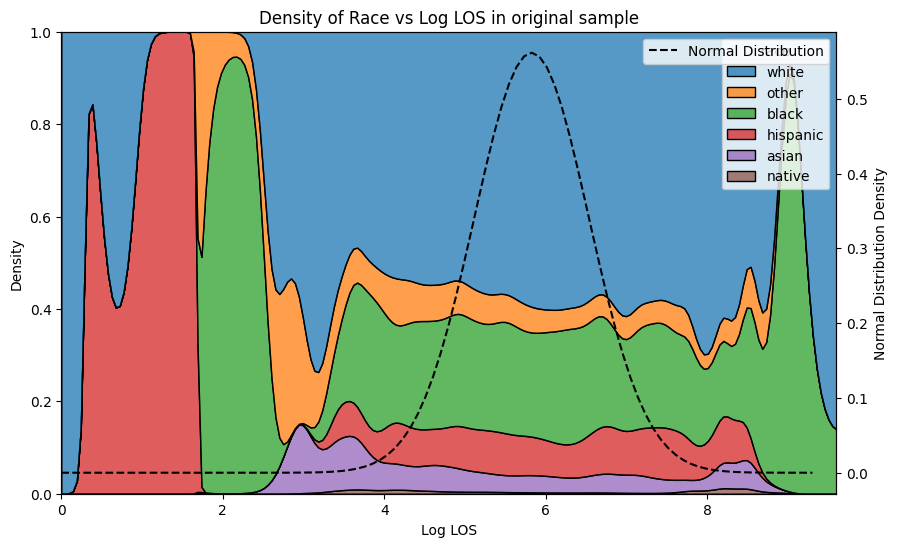

/var/folders/nf/90z5s79x3vd9_8s47vmw3dpw0000gn/T/ipykernel_56519/684740955.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_los'] = np.log(df['los'])


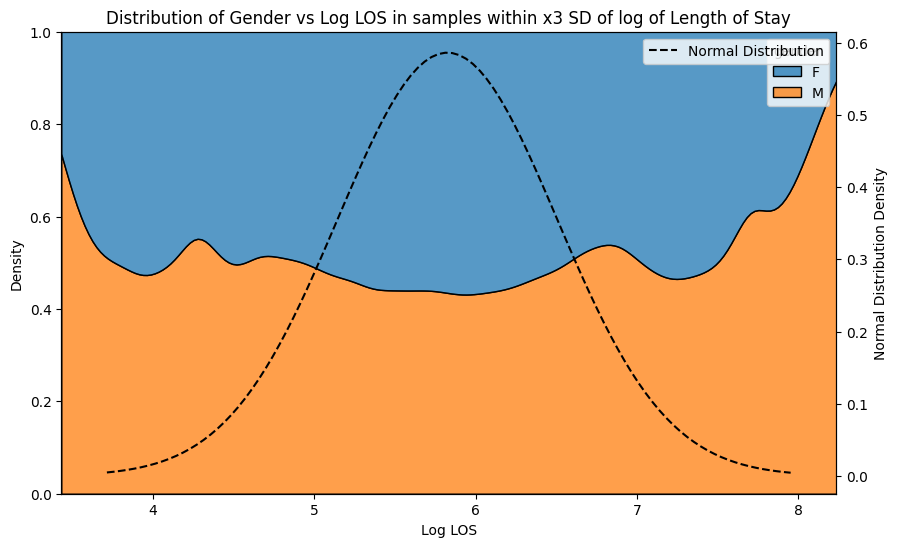

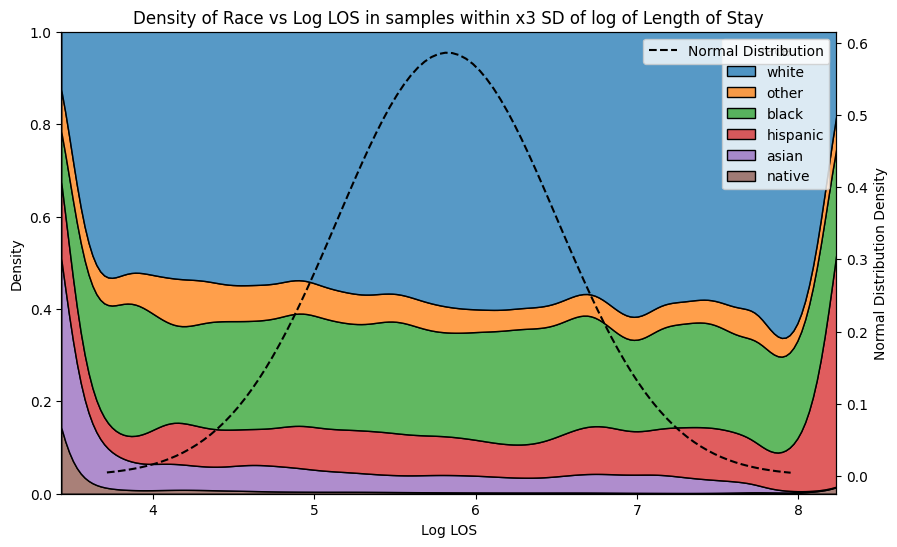

In [47]:
for df in dfs:  # Iterate over the original and trimmed dataframes
    viz_density_race_gender_los(df)  # Visualize density plots for race and gender against log LOS

### Sumary
The exploratory data analysis of Emergency Department (ED) visit stays using the MIMIC-IV database revealed key insights into the relationships between length of stay (LOS) and various demographic and visit-related factors, including race, gender, arrival mode, and disposition type. The analysis highlighted:

- Race and Gender: No significant correlations between LOS and the density of various races or genders, but minorities showed higher densities at the extremes of LOS.
- Arrival Transport and Disposition: Patients arriving by ambulance and those admitted to the hospital tend to have longer ED stays. Transfers had higher densities at the extremes.
- Trimming Data: Trimming the data to include only points within 3 standard deviations of the mean log_los resulted in smoother, more representative distributions.

### Perspective and Recommendations for Further Analysis
 - Statistical Significance: Conduct statistical tests to confirm if observed differences are significant.
 - Detailed Subgroup Analysis: Perform granular analysis of subgroups to identify specific factors influencing LOS.
 - Machine Learning Models: Develop predictive models to identify patients at risk of prolonged ED stays.
 - Policy Implications: Use findings to inform hospital policies aimed at reducing disparities in ED care.

### Conclusion
This analysis provides a foundational understanding of factors influencing ED LOS. Further research and targeted policies can help improve ED operations and patient care outcomes.






